In [140]:
# %matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)

import datetime
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [141]:
# Model with explicit symptomatic category and keeping track of whether recovered were found or not
modelMeta = ({
     'beta * S * (P+A)' : ['S','E1'],
     'gamma * E1' : ['E1','E2'],
     'gamma * E2' : ['E2','P'],
     'gamma * rho * P' : ['P','I'],
     'gamma * (1-rho) * P' : ['P','A'],
     'nu * A' : ['A',None],
     'nu * Q' : ['Q','Rp'],
     # 'nu * I' : ['I',None],
     'nu * I' : ['I','Rp'], # Assuming that symptomatic cases get tested, but aren't included in Q 
     'tau * E2' : ['E2','Q'],
     'tau * P'  : ['P','Q'],
     'tau * A'  : ['A','Q'],
     # 'tau * I'  : ['I','Q'], # Testing of symptomatic cases
     # 'tauInf * I'  : ['I','Q'], # Testing of symptomatic cases
     
},
['S','E1','E2','P','A','Q','I','Rp'],['beta','gamma','nu','rho','tau'])


In [142]:
# Initialize everything
iniExp = 100/5800000

# E1_0 = iniExp 
# E2_0 = 0
# P_0 = 0
E1_0 = iniExp
E2_0 = 0
P_0 = 0  
A_0 = 0 
I_0 = 0 
S_0 = 1 - E1_0 -E2_0 - P_0 - A_0-I_0

init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':0,'I':I_0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
beta = 3*gamma
tau = 0.15
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 250
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])

# changeTest = pmf.Change(10,SetParameters={})
# sch1.addChange(changeTest)

sch1.simulate(tRes=1000)


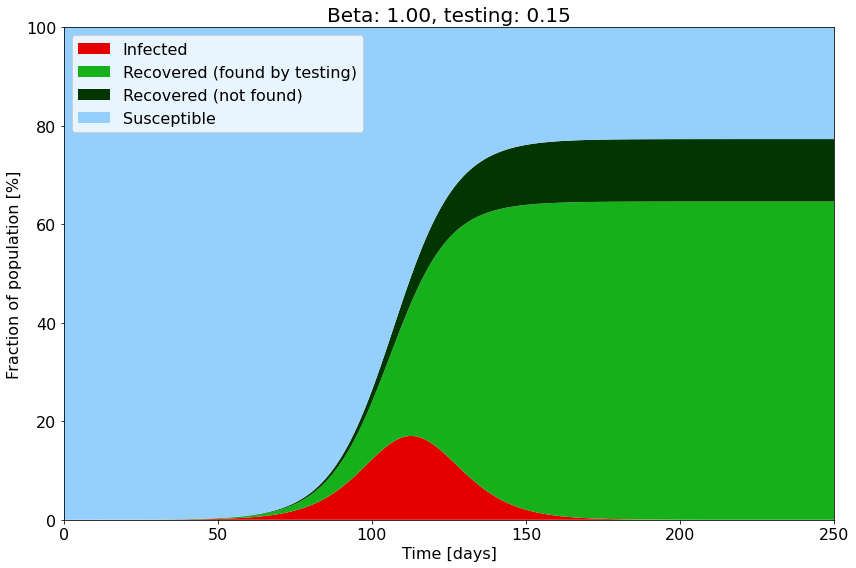

In [143]:
fig,ax = plt.subplots()

allInf = sch1.result.E1 + sch1.result.E2 + sch1.result.P + sch1.result.I + sch1.result.Q + sch1.result.A

Rn = 1 - sch1.result.y.sum(axis=0)

# ax.plot(sch1.result.t,sch1.result.S)
# ax.plot(sch1.result.t,sch1.result.Rp)
# ax.plot(sch1.result.t,Rn)
ax.stackplot(sch1.result.t,
        100*allInf,
        100*sch1.result.Rp,
        100*Rn,
        100*sch1.result.S,
        colors=['xkcd:red','xkcd:green','xkcd:dark green','xkcd:light blue'],
        labels=['Infected','Recovered (found by testing)','Recovered (not found)','Susceptible']
    )

ax.legend(loc='upper left')
ax.set_ylim([0,100])
ax.set_xlim([sch1.result.t[0],sch1.result.t[-1]])

ax.set_xlabel('Time [days]')
ax.set_ylabel('Fraction of population [%]')

strTitle = f'Beta: {beta:2.2f}, testing: {tau:0.2f}'
ax.set_title(strTitle)

fig.tight_layout()

fig.savefig('Figures/TestIntensity_ExampleStacked')

In [144]:
# fig,ax = plt.subplots()

# ax.plot(sch1.result.t,beta*sch1.result.S*(sch1.result.P + sch1.result.A))
# ax.plot(sch1.result.t,allInf)

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_21564\4210615907.py:3: RuntimeWarning: invalid value encountered in true_divide
  curRatio = 100*sch1.result.Rp/(sch1.result.Rp+Rn)


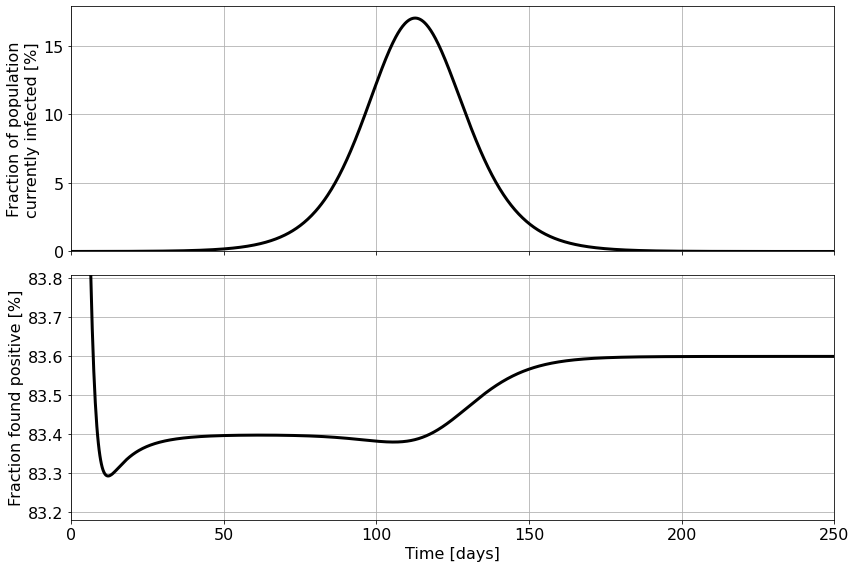

In [145]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True)

curRatio = 100*sch1.result.Rp/(sch1.result.Rp+Rn)

ax.plot(sch1.result.t,100*allInf,'k')
ax2.plot(sch1.result.t,curRatio,'k')

ax2.set_ylim(curRatio[-1]*np.array([0.995,1.0025]))

ax.set_xlim([sch1.result.t[0],sch1.result.t[-1]])
ax2.set_xlim([sch1.result.t[0],sch1.result.t[-1]])
ax.set_ylim(bottom=0)

ax2.set_xlabel('Time [days]')
ax.set_ylabel('Fraction of population\ncurrently infected [%]')
ax2.set_ylabel('Fraction found positive [%]')

ax.grid()
ax2.grid()

fig.tight_layout()
fig.savefig('Figures/TestIntensity_ExampleTestRatio')

# Show some examples with different parameters

In [146]:
def getBetaFromTauAndSigma(tau,sigma,pars):

    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['rho']

    estiTE = (1-sigma)/(gamma+tau)
    estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
    estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

    beta = -np.log(sigma)/(estiTP+estiTA)
    

    return beta 

In [147]:
# Initialize everything
iniExp = 100/5800000

# E1_0 = iniExp 
# E2_0 = 0
# P_0 = 0
E1_0 = iniExp
E2_0 = 0
P_0 = 0  
A_0 = 0 
I_0 = 0 
S_0 = 1 - E1_0 -E2_0 - P_0 - A_0-I_0

init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':0,'I':I_0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
tEnd = 250


beta = 3*gamma
tau = 0.15
pars1 = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}
sch1 = pmf.Scheme(modelMeta,init,pars1,0,tEnd,Changes=[])
sch1.simulate(tRes=1000)

curSigma = sch1.result.S[-1]
newTau = 0.05
newBeta = getBetaFromTauAndSigma(newTau,curSigma,pars1)

# beta = 3*gamma
# tau = 0.05
beta = newBeta
tau = newTau
pars2 = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}
sch2 = pmf.Scheme(modelMeta,init,pars2,0,tEnd,Changes=[])
sch2.simulate(tRes=1000)

beta = 4*gamma
tau = 0.10
pars3 = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}
sch3 = pmf.Scheme(modelMeta,init,pars3,0,tEnd,Changes=[])
sch3.simulate(tRes=1000)


C:\Users\rakrpe\AppData\Local\Temp\ipykernel_21564\2149280757.py:4: RuntimeWarning: invalid value encountered in true_divide
  curRatio1 = 100*sch1.result.Rp/(sch1.result.Rp+Rn1)
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_21564\2149280757.py:5: RuntimeWarning: invalid value encountered in true_divide
  curRatio2 = 100*sch2.result.Rp/(sch2.result.Rp+Rn2)
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_21564\2149280757.py:6: RuntimeWarning: invalid value encountered in true_divide
  curRatio3 = 100*sch3.result.Rp/(sch3.result.Rp+Rn3)


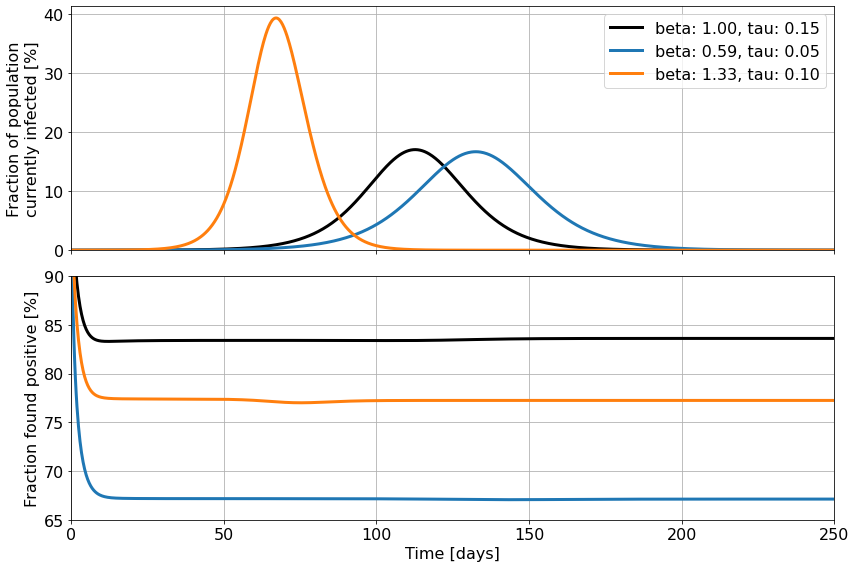

In [148]:

Rn1 = 1 - sch1.result.y.sum(axis=0)
Rn2 = 1 - sch2.result.y.sum(axis=0)
Rn3 = 1 - sch3.result.y.sum(axis=0)
curRatio1 = 100*sch1.result.Rp/(sch1.result.Rp+Rn1)
curRatio2 = 100*sch2.result.Rp/(sch2.result.Rp+Rn2)
curRatio3 = 100*sch3.result.Rp/(sch3.result.Rp+Rn3)

allInf1 = sch1.result.E1 + sch1.result.E2 + sch1.result.P + sch1.result.I + sch1.result.Q + sch1.result.A
allInf2 = sch2.result.E1 + sch2.result.E2 + sch2.result.P + sch2.result.I + sch2.result.Q + sch2.result.A
allInf3 = sch3.result.E1 + sch3.result.E2 + sch3.result.P + sch3.result.I + sch3.result.Q + sch3.result.A

fig,(ax,ax2) = plt.subplots(2,1,sharex=True)


curBeta = pars1['beta']
curTau = pars1['tau']
ax.plot(sch1.result.t,100*allInf1,'k',label=f'beta: {curBeta:2.2f}, tau: {curTau:2.2f}')
curBeta = pars2['beta']
curTau = pars2['tau']
ax.plot(sch1.result.t,100*allInf2,label=f'beta: {curBeta:2.2f}, tau: {curTau:2.2f}')
curBeta = pars3['beta']
curTau = pars3['tau']
ax.plot(sch1.result.t,100*allInf3,label=f'beta: {curBeta:2.2f}, tau: {curTau:2.2f}')
ax2.plot(sch1.result.t,curRatio,'k')
ax2.plot(sch1.result.t,curRatio2)
ax2.plot(sch1.result.t,curRatio3)

# ax2.set_ylim(curRatio[-1]*np.array([0.995,1.0025]))
ax.legend()

ax.set_xlim([sch1.result.t[0],sch1.result.t[-1]])
ax2.set_xlim([sch1.result.t[0],sch1.result.t[-1]])
ax.set_ylim(bottom=0)

ax2.set_xlabel('Time [days]')
ax.set_ylabel('Fraction of population\ncurrently infected [%]')
ax2.set_ylabel('Fraction found positive [%]')

ax2.set_ylim([65,90])

ax.grid()
ax2.grid()

fig.tight_layout()
fig.savefig('Figures/TestIntensity_ExampleTestRatioMultiple')

# Make an example of changing testing in the middle of epidemic

In [162]:
# Initialize everything
iniExp = 100/5800000

E1_0 = iniExp
E2_0 = 0
P_0 = 0  
A_0 = 0 
I_0 = 0 
S_0 = 1 - E1_0 -E2_0 - P_0 - A_0-I_0

init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':0,'I':I_0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
beta = 3*gamma
tau = 0.15
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 250
sch1_change = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])

changeTest = pmf.Change(120,SetParameters={'tau':0.05})
sch1_change.addChange(changeTest)

sch1_change.simulate(tRes=1000)


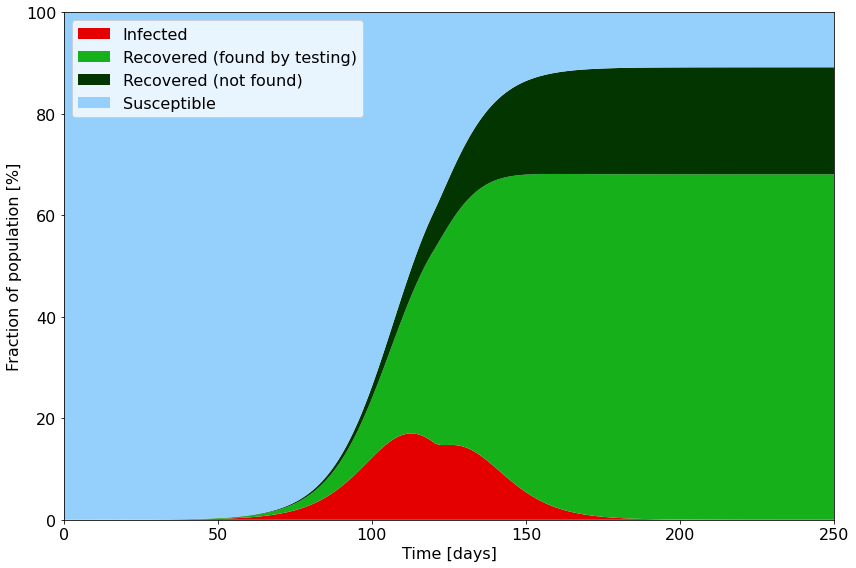

In [163]:
fig,ax = plt.subplots()

allInf_change = sch1_change.result.E1 + sch1_change.result.E2 + sch1_change.result.P + sch1_change.result.I + sch1_change.result.Q + sch1_change.result.A

Rn_change = 1 - sch1_change.result.y.sum(axis=0)

# ax.plot(sch1_change.result.t,sch1_change.result.S)
# ax.plot(sch1_change.result.t,sch1_change.result.Rp)
# ax.plot(sch1_change.result.t,Rn_change)
ax.stackplot(sch1_change.result.t,
        100*allInf_change,
        100*sch1_change.result.Rp,
        100*Rn_change,
        100*sch1_change.result.S,
        colors=['xkcd:red','xkcd:green','xkcd:dark green','xkcd:light blue'],
        labels=['Infected','Recovered (found by testing)','Recovered (not found)','Susceptible']
    )

ax.legend(loc='upper left')
ax.set_ylim([0,100])
ax.set_xlim([sch1_change.result.t[0],sch1_change.result.t[-1]])

ax.set_xlabel('Time [days]')
ax.set_ylabel('Fraction of population [%]')

# strTitle = f'Beta: {beta:2.2f}, testing: {tau:0.2f}'
# ax.set_title(strTitle)

fig.tight_layout()

fig.savefig('Figures/TestIntensity_ExampleStackedChange')

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_21564\2823594715.py:14: RuntimeWarning: invalid value encountered in true_divide
  curRatio = sch1.result.Rp/(sch1.result.Rp+Rn)
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_21564\2823594715.py:15: RuntimeWarning: invalid value encountered in true_divide
  curRatio_change = sch1_change.result.Rp/(sch1_change.result.Rp+Rn_change)


(0.75, 0.85)

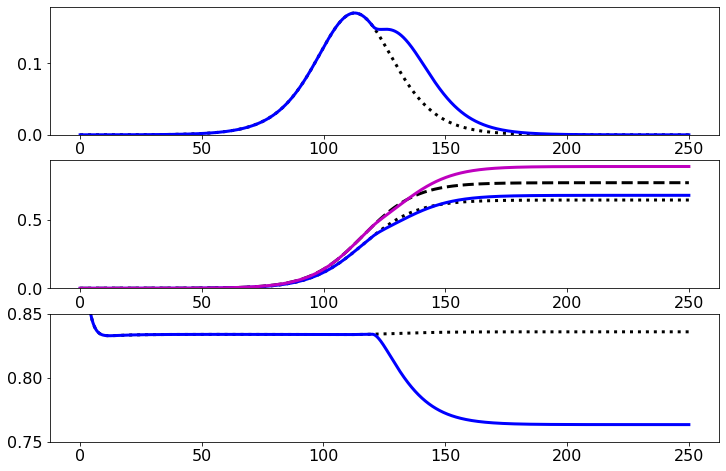

In [177]:
fig,(ax,ax2,ax3) = plt.subplots(3,1)

ax.plot(sch1.result.t,allInf,'k:')
ax.plot(sch1_change.result.t,allInf_change,'b')
# fig,(ax2,ax3) = plt.subplots(2,1)

# ax2.stackplot(sch1.result.t,sch1.result.Rp,Rn,colors=['xkcd:dark gray','xkcd:gray'])
ax2.plot(sch1.result.t,sch1.result.Rp,'k:')
ax2.plot(sch1.result.t,sch1.result.Rp+Rn,'k--')
ax2.plot(sch1_change.result.t,sch1_change.result.Rp,'b')
ax2.plot(sch1_change.result.t,sch1_change.result.Rp+Rn_change,'m')


curRatio = sch1.result.Rp/(sch1.result.Rp+Rn)
curRatio_change = sch1_change.result.Rp/(sch1_change.result.Rp+Rn_change)

ax3.plot(sch1.result.t,curRatio,'k:')
ax3.plot(sch1_change.result.t,curRatio_change,'b')

ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax3.set_ylim([0.75,0.85])

# ax.plot(sch1.result.t,sch1.result.Rp,'k:')
# ax.plot(sch1_change.result.t,sch1_change.result.Rp,'b')
# ax2.plot(sch1.result.t,Rn,'k:')
# ax2.plot(sch1_change.result.t,Rn_change,'b')

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_21564\2115170259.py:4: RuntimeWarning: invalid value encountered in true_divide
  curRatio = sch1.result.Rp/(sch1.result.Rp+Rn)
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_21564\2115170259.py:5: RuntimeWarning: invalid value encountered in true_divide
  curRatio_change = sch1_change.result.Rp/(sch1_change.result.Rp+Rn_change)


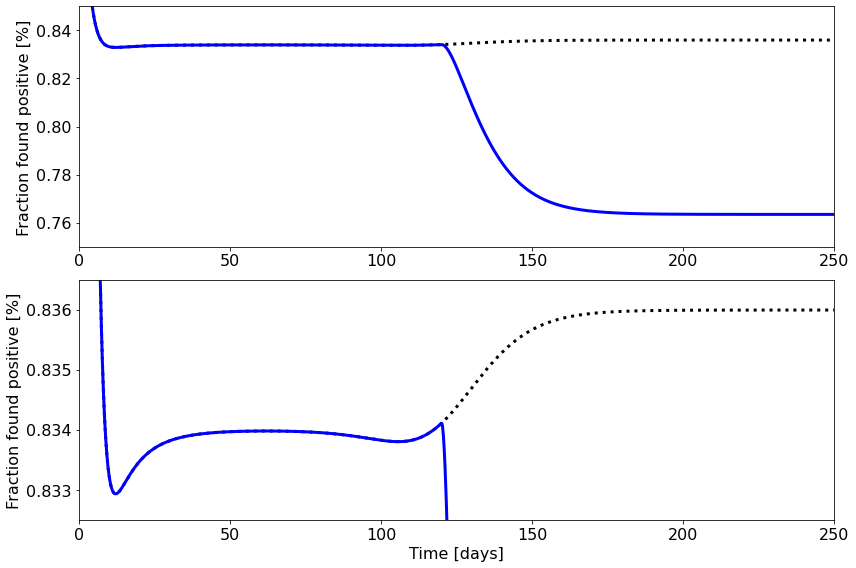

In [194]:

fig,(ax,ax2) = plt.subplots(2,1)


curRatio = sch1.result.Rp/(sch1.result.Rp+Rn)
curRatio_change = sch1_change.result.Rp/(sch1_change.result.Rp+Rn_change)

ax.plot(sch1.result.t,curRatio,'k:')
ax.plot(sch1_change.result.t,curRatio_change,'b')
ax2.plot(sch1.result.t,curRatio,'k:')
ax2.plot(sch1_change.result.t,curRatio_change,'b')

ax.set_ylim([0.75,0.85])
ax2.set_ylim([0.8325,0.8365])

# ax.plot(sch1.result.t,sch1.result.Rp,'k:')
# ax.plot(sch1_change.result.t,sch1_change.result.Rp,'b')
# ax2.plot(sch1.result.t,Rn,'k:')
# ax2.plot(sch1_change.result.t,Rn_change,'b')

ax.set_ylabel('Fraction found positive [%]')
ax2.set_ylabel('Fraction found positive [%]')
ax.set_xlim([sch1_change.result.t[0],sch1_change.result.t[-1]])
ax2.set_xlim([sch1_change.result.t[0],sch1_change.result.t[-1]])

ax2.set_xlabel('Time [days]')

fig.tight_layout()

fig.savefig('Figures/TestIntensity_ExampleChangeRatio')